In [1]:

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
# DATA FILES

price_files = ["bittensor_token_price.csv", "fetchai_token_price.csv",
               "numerai_token_price.csv", "oceanprotocol_token_price.csv",
               "oraichain_token_price.csv", "singularitynet_token_price.csv"]

commits_mapping = {
    "bittensor_commits.json": "TAO",
    "fetchai_commits.json": "FET",
    "numerai_commits.json": "NMR", 
    "oceanprotocol_commits.json": "OCEAN",
    "oraichain_commits.json": "ORAI",
    "singularitynet_commits.json": "AGIX"
}

issues_mapping = {
    "bittensor_issues.json": "TAO",
    "fetchai_issues.json": "FET",
    "numerai_issues.json": "NMR", 
    "oceanprotocol_issues.json": "OCEAN",
    "oraichain_issues.json": "ORAI",
    "singularitynet_issues.json": "AGIX"
}

repos_mapping = {
    "bittensor_repos.json": "TAO",
    "fetchai_repos.json": "FET",
    "numerai_repos.json": "NMR", 
    "oceanprotocol_repos.json": "OCEAN",
    "oraichain_repos.json": "ORAI",
    "singularitynet_repos.json": "AGIX"
}

tokens = ["TAO", "FET", "NMR",
          "OCEAN", "ORAI", "AGIX"]



In [3]:
def get_commits(token, mapping):
    for k, v in mapping.items():
        if token == v:
            filename = f'github_data/{k}'
            with open(filename) as commits_file:
                parsed_json = json.load(commits_file)
            
            commits_rows = [row for sublist in parsed_json for row in sublist]
            commits_df = pd.DataFrame(commits_rows)
            return commits_df
    return f'No commit data for token {token}'

def get_issues(token, mapping):
    for k, v in mapping.items():
        if token == v:
            filename = f'github_data/{k}'
            with open(filename) as issues_files:
                parsed_json = json.load(issues_files)
            
            issues_rows = [row for sublist in parsed_json for row in sublist]
            issues_df = pd.DataFrame(issues_rows)
            return issues_df
    return f'No gh issues data for token {token}'

def load_price_data(token, tokens_list, price_files):
    idx = tokens_list.index(token)
    filename = f'price/{price_files[idx]}'
    return pd.read_csv(filename)



In [27]:
def clean_price_data(price_df):

    price_df['Date'] = pd.to_datetime(price_df['Date'])
    price_df['Year'] = pd.to_datetime(price_df['Date']).dt.year
    price_df['Month'] = pd.to_datetime(price_df['Date']).dt.month
    price_df['Day'] = pd.to_datetime(price_df['Date']).dt.day
    
    useful_columns = ['Date', 'Close', 'Volume', 'Year', 'Month', 'Day']
    price_df = price_df[useful_columns]
    return price_df

def get_commit_trends(commits_df):
    flat_commit = pd.json_normalize(commits_df['commit'])
    commits_df = pd.concat([commits_df, flat_commit], axis=1)
    commits_df.drop(columns=['commit'], inplace=True)

    commits_df['author.date'] = pd.to_datetime(commits_df['author.date']).dt.date

    date_counts = pd.DataFrame()

    date_counts['commit_count'] = commits_df['author.date'].value_counts()

    
    # Reset index to make the date a column
    date_counts = date_counts.reset_index()
    date_counts.columns = ['date', 'commit_count']

    # Convert 'date' column to datetime
    date_counts['date'] = pd.to_datetime(date_counts['date'])
    date_counts['year'] = pd.to_datetime(date_counts['date']).dt.year

    # Set 'date' column as the index
    date_counts.set_index('date', inplace=True)

    # Resample into daily intervals and fill missing dates with zeros
    daily_counts = date_counts.asfreq('D', fill_value=0)

    # Resample into monthly and quarterly intervals
    yearly_counts = date_counts.resample('Y').agg({'commit_count': 'sum', 'year': 'first'})
    monthly_counts = date_counts.resample('M').agg({'commit_count': 'sum', 'year': 'first'})
    weekly_counts = date_counts.resample('W').agg({'commit_count': 'sum', 'year': 'first'})

    return daily_counts, yearly_counts, monthly_counts, weekly_counts

In [28]:
def merging_df(price_df, trend_df, time_frame):
    #Resample data into Weekly data from daily
    temporal_price = price_df.set_index('Date')

    temporal_df = temporal_price.resample(time_frame).agg({'Close': 'last', 'Volume': 'sum', 'Year': 'last', 'Month': 'last', 'Day': 'last'})
    temporal_df.reset_index(inplace=True)

    trend_df.reset_index(inplace=True)
    
    # Set the timeframe for merging
    point0 = trend_df['date'][0]

    price_trend = temporal_df[temporal_df['Date']>=point0]
    price_trend.reset_index(inplace=True, drop=True)

    

    price_trend =  pd.merge(price_trend, trend_df, how='left', left_on='Date', right_on='date')
    price_trend = price_trend[['Date', 'Close', 'Volume', 'Year', 'Month', 'commit_count']]
    return price_trend

In [29]:
bittensor = get_commits('TAO', commits_mapping)
daily_trends, yearly, monthly, weekly = get_commit_trends(bittensor)

tao_price = load_price_data('TAO', tokens, price_files)
clean_price = clean_price_data(tao_price)


In [32]:
def correlations(df, token, ax=None):
    correlations = df.corr()
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
    else:
        fig = ax.get_figure()
    sns.heatmap(correlations, annot=True, linewidths=.5, ax=ax, cmap="mako")
    ax.set_title(f'Correlations for {token}')
    fig.tight_layout()
    return ax

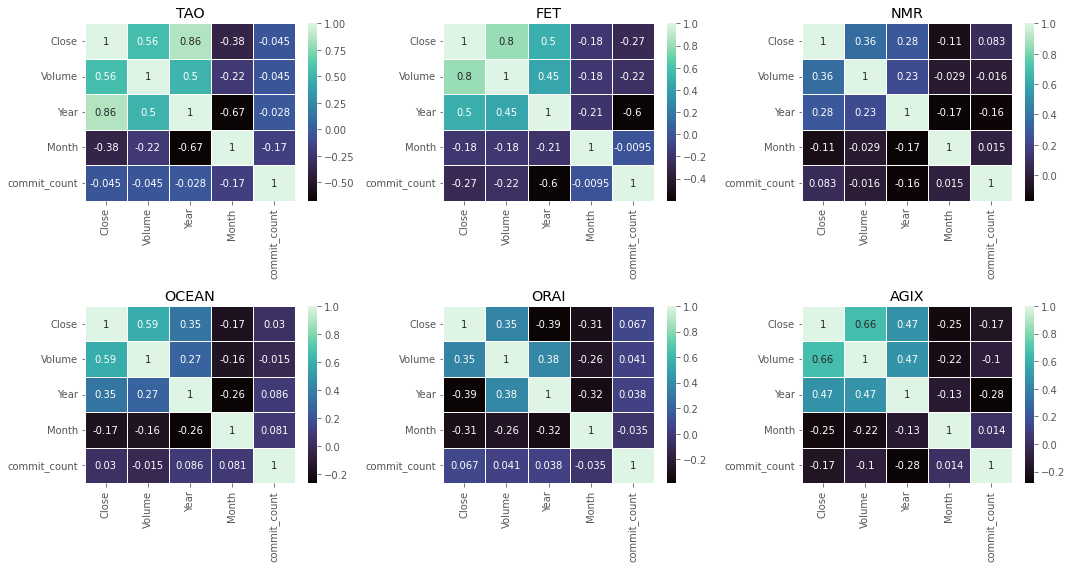

In [47]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Daily Correlations for commits

for i, token in enumerate(tokens):
    commits_df = get_commits(token, commits_mapping)
    commits_trends = get_commit_trends(commits_df) #a tuple containing all dfs (daily, yearly, monthly, weekly )
    price_df = load_price_data(token, tokens, price_files)
    clean_price = clean_price_data(price_df)
    price_trend_df = merging_df(clean_price, commits_trends[0], 'D')
    ax = axes[i // 3, i % 3]  # Get the appropriate subplot axes
    correlations(price_trend_df, token, ax=ax)
    ax.set_title(token)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

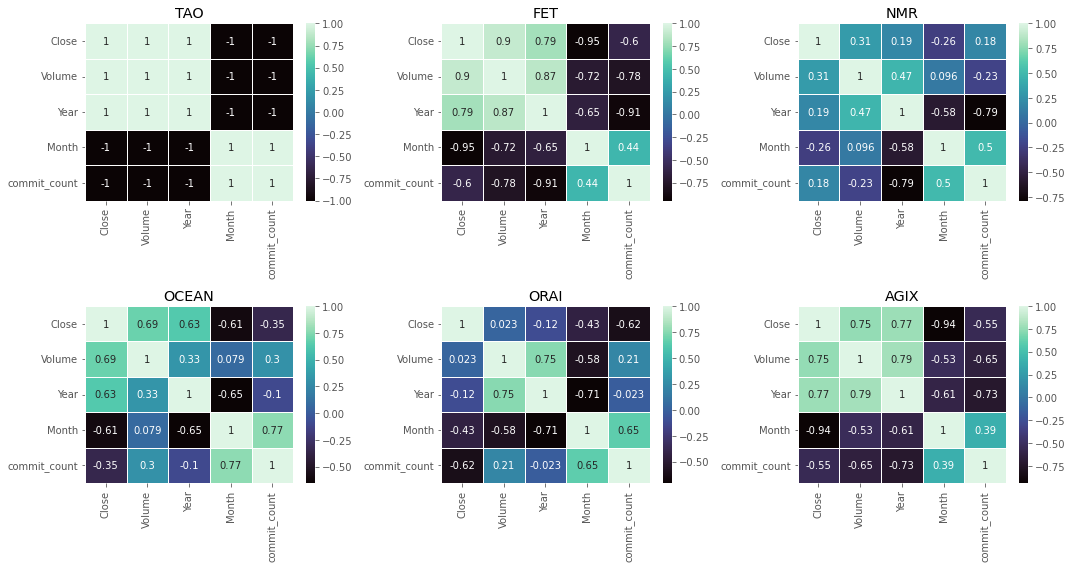

In [48]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Yearly Correlations for commits

for i, token in enumerate(tokens):
    commits_df = get_commits(token, commits_mapping)
    commits_trends = get_commit_trends(commits_df) #a tuple containing all dfs (daily, yearly, monthly, weekly )
    price_df = load_price_data(token, tokens, price_files)
    clean_price = clean_price_data(price_df)
    price_trend_df = merging_df(clean_price, commits_trends[1], 'Y')
    ax = axes[i // 3, i % 3]  # Get the appropriate subplot axes
    correlations(price_trend_df, token, ax=ax)
    ax.set_title(token)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

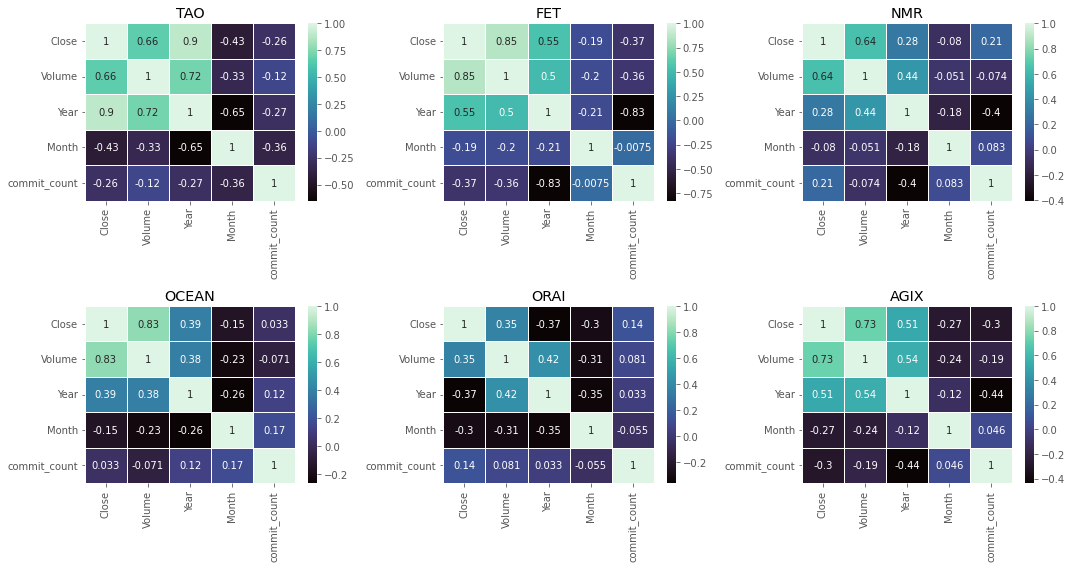

In [49]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Monthly Correlations for commits

for i, token in enumerate(tokens):
    commits_df = get_commits(token, commits_mapping)
    commits_trends = get_commit_trends(commits_df) #a tuple containing all dfs (daily, yearly, monthly, weekly )
    price_df = load_price_data(token, tokens, price_files)
    clean_price = clean_price_data(price_df)
    price_trend_df = merging_df(clean_price, commits_trends[2], 'M')
    ax = axes[i // 3, i % 3]  # Get the appropriate subplot axes
    correlations(price_trend_df, token, ax=ax)
    ax.set_title(token)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

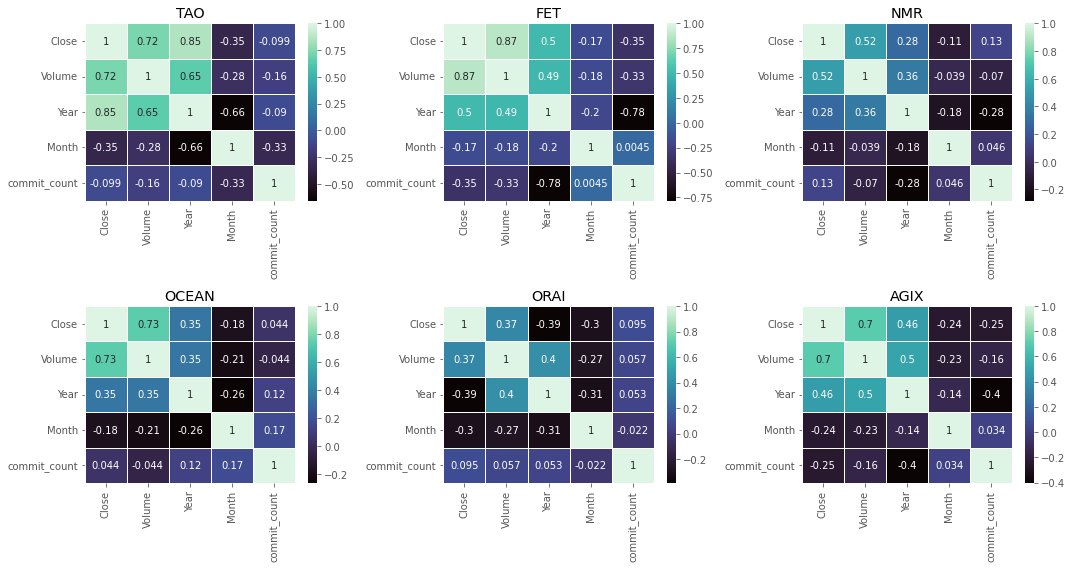

In [50]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Weekly Correlations for commits

for i, token in enumerate(tokens):
    commits_df = get_commits(token, commits_mapping)
    commits_trends = get_commit_trends(commits_df) #a tuple containing all dfs (daily, yearly, monthly, weekly )
    price_df = load_price_data(token, tokens, price_files)
    clean_price = clean_price_data(price_df)
    price_trend_df = merging_df(clean_price, commits_trends[3], 'W')
    ax = axes[i // 3, i % 3]  # Get the appropriate subplot axes
    correlations(price_trend_df, token, ax=ax)
    ax.set_title(token)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [52]:
def plot_data(merged_df, n_cols, token):

    fig, axes = plt.subplots(nrows=1, ncols=n_cols, figsize=(30, 8))
    fig.tight_layout(pad=5.0)

    axes[0].plot(merged_df['Date'], merged_df['Close'])
    axes[1].plot(merged_df['Date'], np.log(merged_df['Volume']))
    axes[0].set(xlabel='Date', ylabel='Price (USD)', title=f'{token}-USD Chart')
    axes[1].set(xlabel='Date', ylabel='log(Volume)', title=f'{token}-USD Volume')

    if n_cols == 3:
        axes[2].plot(merged_df['Date'], merged_df['commit_count'])
        axes[2].set(xlabel='Date', ylabel='Commit Count', title=f"{token}'s gh Commits Trend")


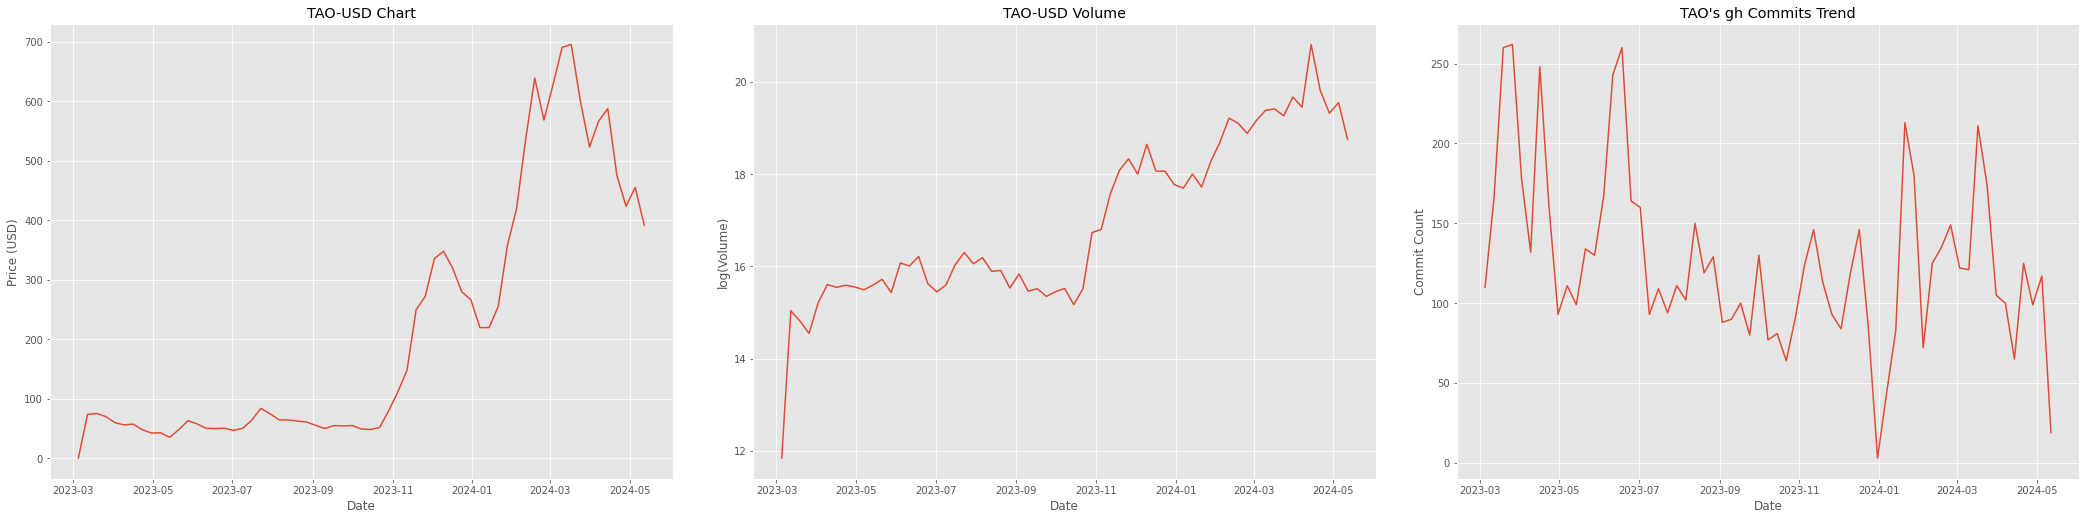

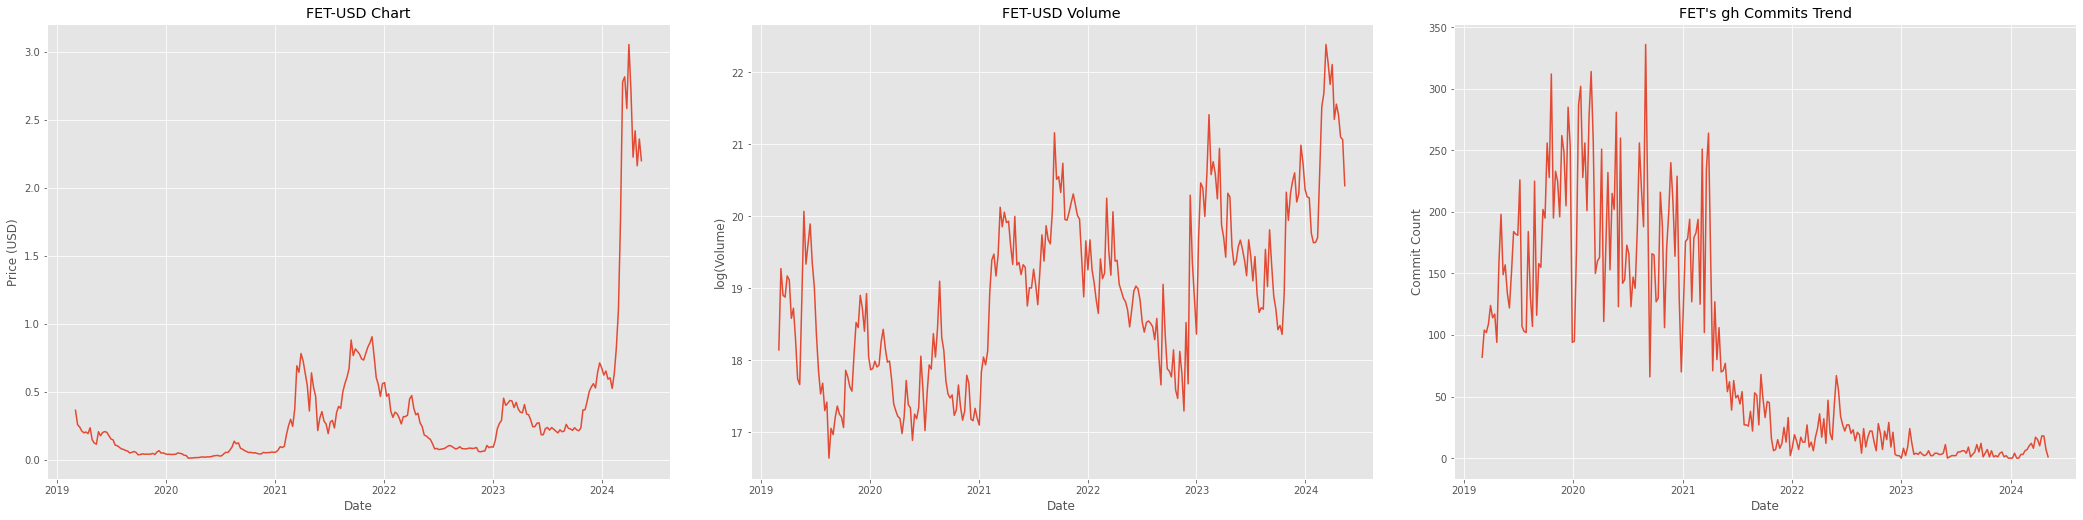

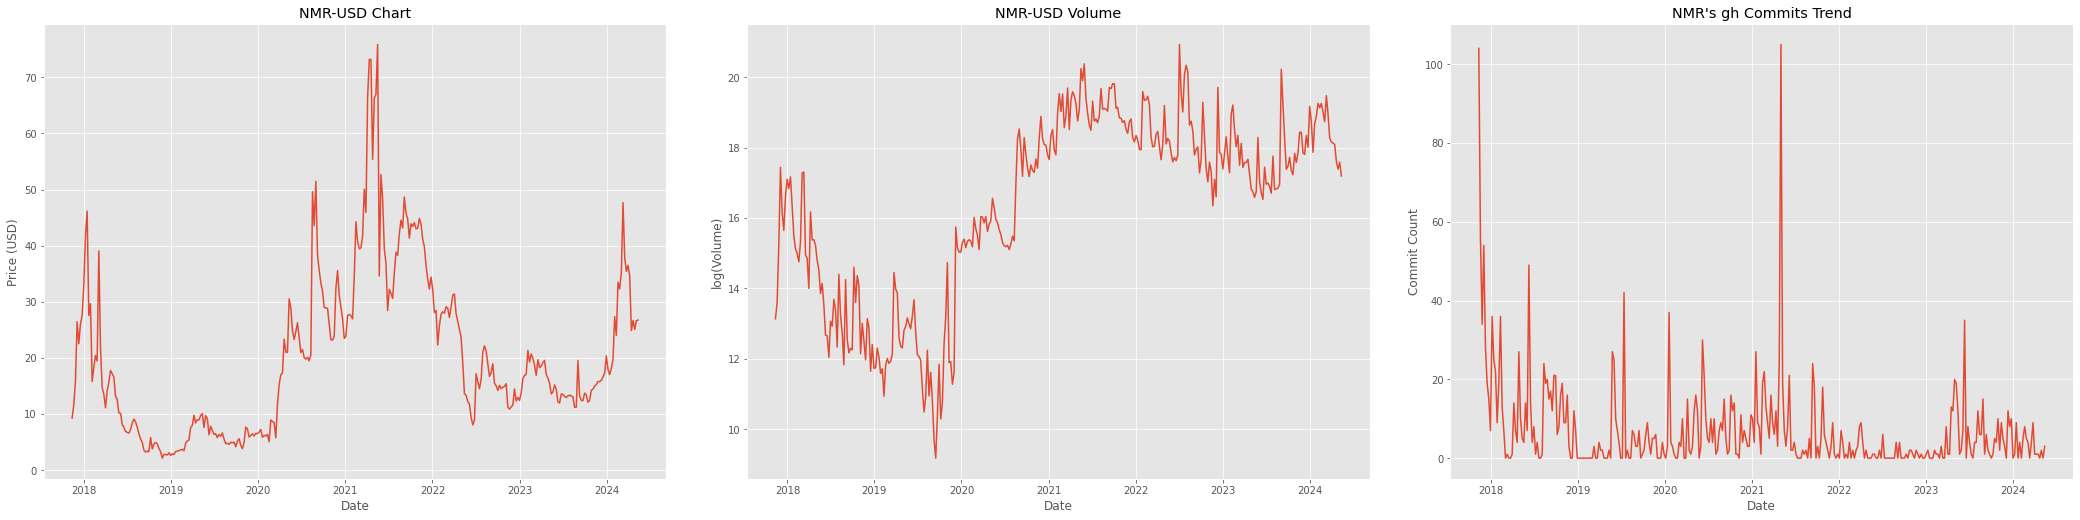

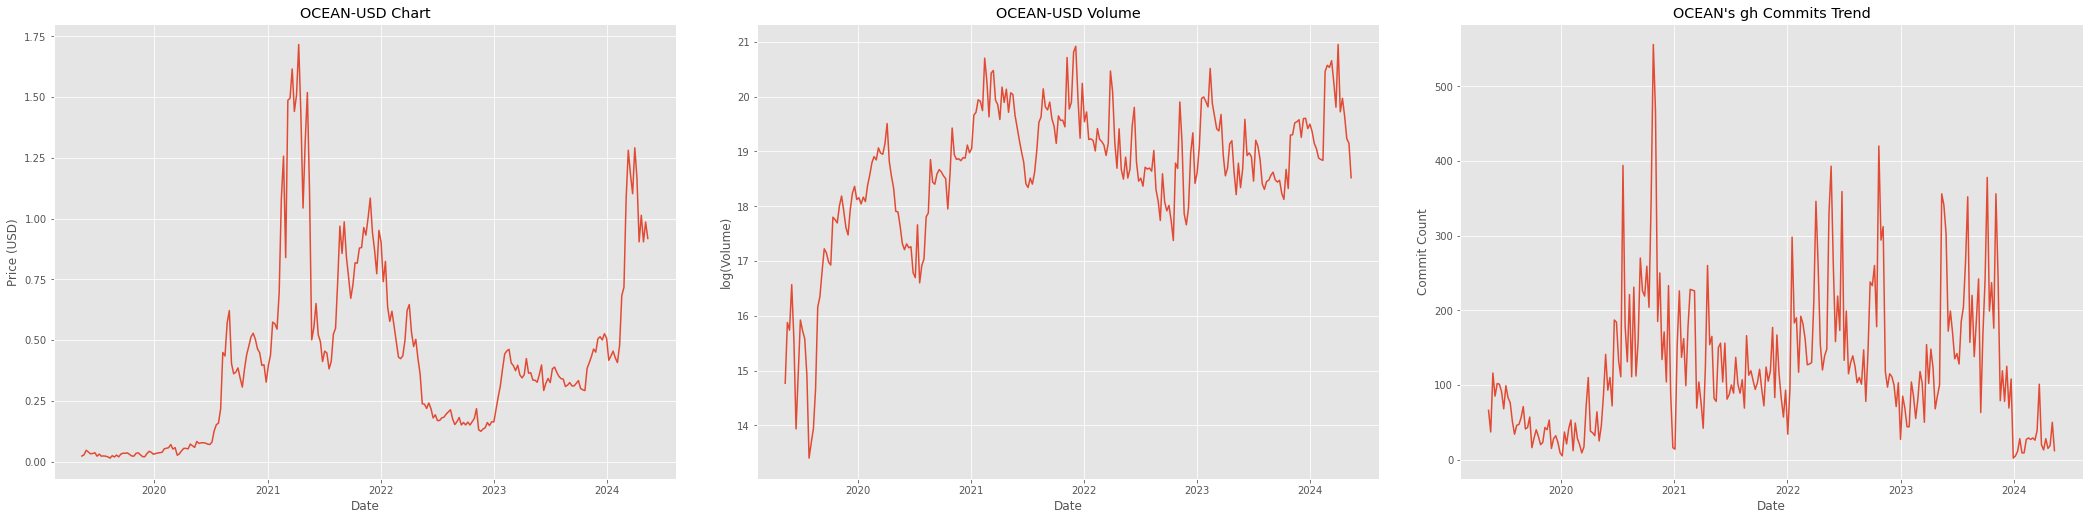

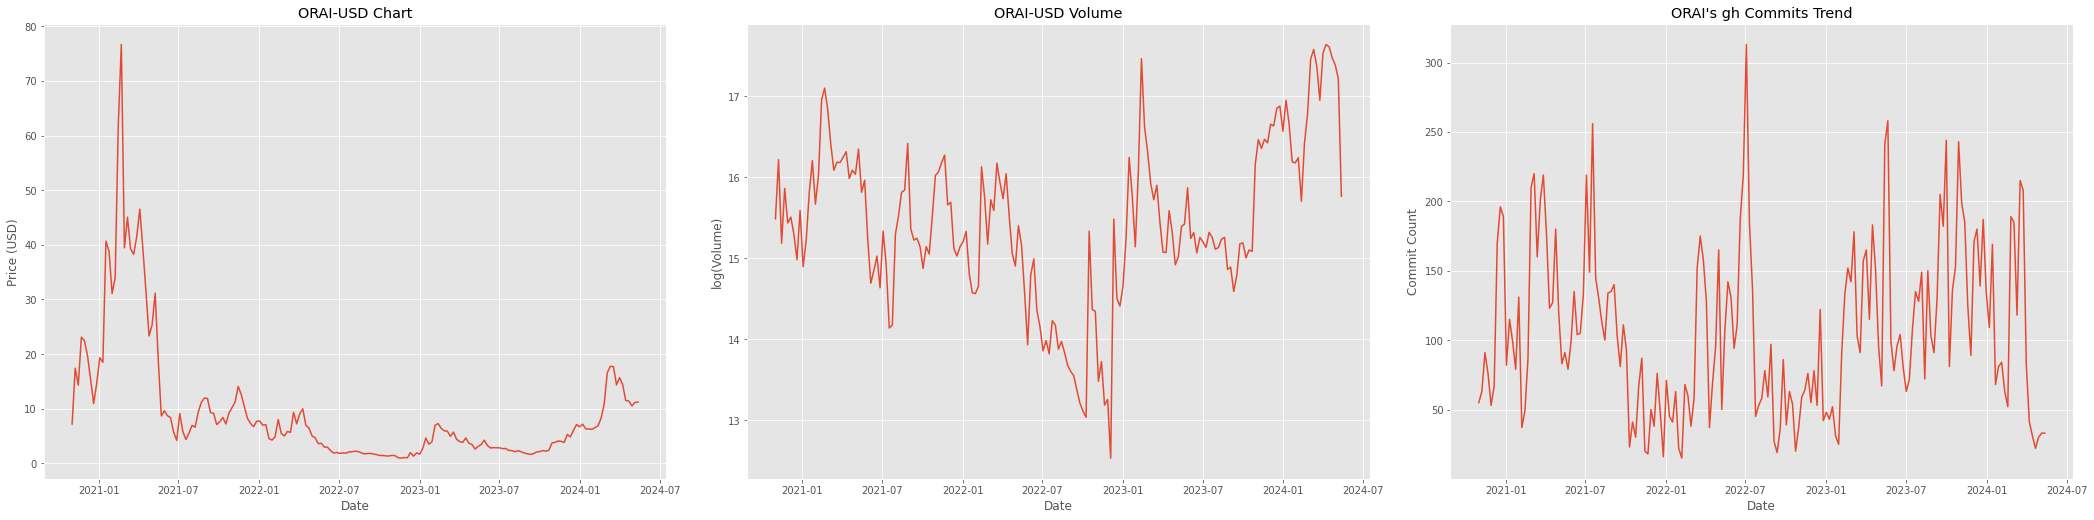

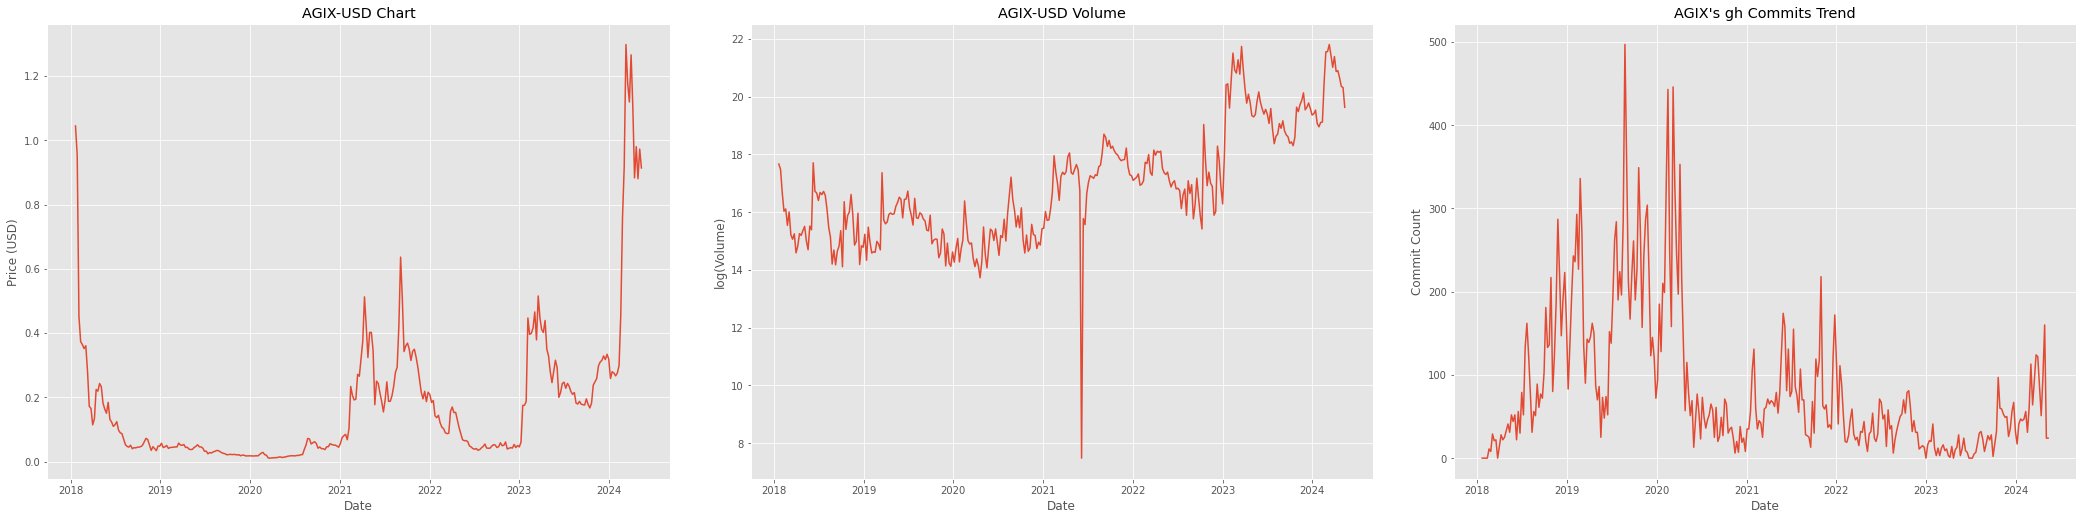

In [53]:
for i, token in enumerate(tokens):
    commits_df = get_commits(token, commits_mapping)
    commits_trends = get_commit_trends(commits_df) #a tuple containing all dfs (daily, yearly, monthly, weekly )
    price_df = load_price_data(token, tokens, price_files)
    clean_price = clean_price_data(price_df)
    price_trend_df = merging_df(clean_price, commits_trends[3], 'W')
    plot_data(price_trend_df, 3, token)